# Mediterranean Sea - SWOT CalVal: overview of llc parcel simulation

In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

from dask.delayed import delayed
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

import warnings
warnings.filterwarnings('ignore')

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5162408.datarmor0/parcels-55081/libparcels_random_746baaf9-01cc-49c9-9b4f-a34e15a1f8af.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=5)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
cluster

---
## load data

In [11]:
flag_write_subset = True

if flag_write_subset:
    root_dir = '/home1/datawork/aponte/parcels/'
    run_name = 'global_extra_T365j_dt1j_dij50'

    p = pa.parcels_output(root_dir+run_name, 
                          parquets=['time', 'trajectory'],
                          parquet_kwargs=dict(gather_statistics=False), # ? infer_divisions? 
                         )
    df = p['time']

    t_start = df.index.min().compute()
    t_end = df.index.max().compute()

    df.head()

---

## Small zoom

In [5]:
def get_background(region, **kwargs):
    dkwargs = dict(dij=1, 
                   v="SST", vmin=10, vmax=16,
                   colorbar=True, 
                   land=True,
                   swot_tracks=True, 
                   figsize=(10, 10),
                  )
    dkwargs.update(region=region, **kwargs)
    return dkwargs

def get_proj(extent):
    lon = (extent[0]+extent[1])*.5
    lat = (extent[2]+extent[3])*.5
    return ccrs.Orthographic(central_longitude=lon, 
                     central_latitude=lat, 
                     globe=None,
                    )

In [12]:
#extent = [-128, -123, 33, 38] # large box
extent = [3, 6.5, 40, 44] # small bbox

region = dict(faces = [2],
              extent = extent,
              projection = get_proj(extent),
              dticks = [1,1],
             )

background = get_background(region)

In [13]:
t_range = pd.date_range("2012-1-1", "2012-2-1", freq="12H")

In [14]:
parquet_path = "/home1/scratch/aponte/zoom_medsea_drifters"
llc_path = "/home1/scratch/aponte/zoom_medsea_llc"

if flag_write_subset:
    
    # store drifter data
    parquet_path = pa.filter_drifters_regionally(df, 
                                              extent, 
                                              t_range=t_range,
                                              parquet_dir=parquet_path,                                                 
                                             )
    # store llc data
    background['zarr'] = ut.filter_llc_regionally(t_range,
                                              background=background, 
                                              zarr = llc_path,
                                             )    

No reindexing
create new archive: /home1/scratch/aponte/zoom_drifters


In [9]:
# to turn off manual color limits
#background = get_background(region, vmin=None, vmax=None)
#background = get_background(region, vmin=10, vmax=16)

kwargs = dict(t_delta='1H',
              parquet_dir=parquet_path,              
              flag_drifters=0,
              drifter_kwargs={"color": "cadetblue"},
              trail='5D',
              background=background,
              overwrite=True,
             )

background printed


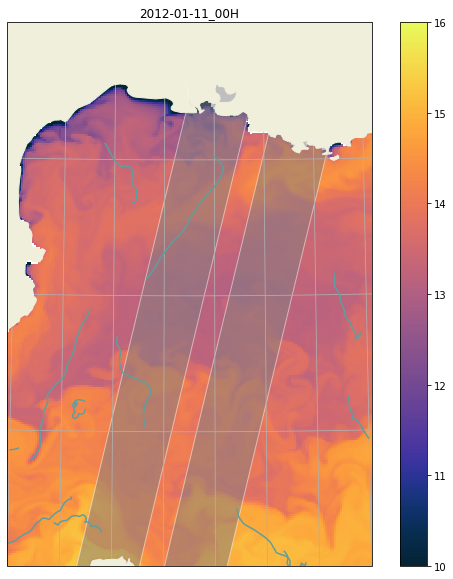

In [16]:
# to create isolated figures:
t_start = t_range[0] + pd.Timedelta('10D')
t_end = t_start #+ pd.Timedelta('1H')

pa.plot_llc_parcels(t_start, t_end, offline=False, **kwargs)

### go for it

In [17]:

Nb = len(client.nthreads())
rg = range(0, t_range.size-1)
if len(rg)/Nb>1:
    II = np.array_split(rg,len(rg)/Nb)
else:
    II = [list(rg)]  
print('%d batches to be done'%len(II))

1 batches to be done


In [18]:
#
delayed_fig = delayed(pa.plot_llc_parcels)
#
for I in II:
    print(' batch %d-%d'%(I[0],I[-1]))
    values = [delayed_fig(t_range[i], t_range[i+1], **kwargs) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

 batch 0-61


---
## close cluster

In [19]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
for f in futures:
    f.cancel()